# Build Environment

In [ ]:
import numpy as np

class build_environment(object):

  def __init__(self, K, threshold, T, trials):
    self.K = K + 1
    self.mu = None
    self.mu_t = None
    self.threshold = threshold
    self.true_epsilon_arms = []
    self.T = T
    self.trials = trials
    self.G = None
    self.sig = .1
    self.safe_arm = None

    self.baseline = self.K - 1


    
    
    self.best_arm = None

  def find_safe_arms(self, mu):

    safe_set = []
    for k in range(0,self.K-1):
      if mu[k] >= self.alpha*self.threshold:
        safe_set.append(k)
    
    return safe_set

  
  def build_env1(self,):

    self.changepoint_time = [int(self.T/4.0), int((2/4.0)*self.T), int((3/4.0)*self.T), self.T]
    self.G = len(self.changepoint_time)
    print( self.changepoint_time, self.G)

    #self.safe_arm = 2

    self.best_arm = np.zeros(self.G)
    self.mu = np.zeros((self.G, self.K))
    #self.time_change = np.zeros((self.G, self.K))
    self.mu_t = np.zeros((self.T,self.K))
    self.safe_arm_t = np.zeros((self.T,3))
    
    self.baseline = self.K - 1
    self.mu_baseline = 0.35
    
    self.mu[0, :] = [0.2, 0.65, 0.5, 0.3, 0.8, self.mu_baseline]
    self.best_arm[0] = np.argmax(self.mu[0])
    self.mu_t[0:self.changepoint_time[0],:] = self.mu[0,:]
    #self.safe_arm_t[0:self.changepoint_time[0],:] = tuple(self.find_safe_arms(self.mu[0, :]))

    self.mu[1, :] = [0.7, 0.65, 0.5, 0.3, 0.25, self.mu_baseline] 
    self.best_arm[1] = np.argmax(self.mu[1])
    self.mu_t[self.changepoint_time[0]:self.changepoint_time[1],:] = self.mu[1,:]
    #self.safe_arm_t[self.changepoint_time[0]:self.changepoint_time[1],:] = (self.find_safe_arms(self.mu[1, :]))

    self.mu[2, :] = [0.1, 0.65, 0.5, 0.8, 0.25, self.mu_baseline] 
    self.best_arm[2] = np.argmax(self.mu[2])
    self.mu_t[self.changepoint_time[1]:self.changepoint_time[2],:] = self.mu[2,:]
    #self.safe_arm_t[self.changepoint_time[1]:self.changepoint_time[2],:] = (self.find_safe_arms(self.mu[2, :]))

    self.mu[3, :] = [0.65, 0.65, 0.5, 0.3, 0.75, self.mu_baseline] 
    self.best_arm[3] = np.argmax(self.mu[3])
    self.mu_t[self.changepoint_time[2]:self.changepoint_time[3],:] = self.mu[3,:]
    #self.safe_arm_t[self.changepoint_time[2]:self.changepoint_time[3],:] = (self.find_safe_arms(self.mu[3, :]))

  def pull_arm(self, arm, t):

    return self.mu_t[t][arm] + self.sig*np.random.randn()
    
# obj = build_environment(10, 0.1, 1000, 10)
# obj.build_env3()
# print(obj.mu)
# print(obj.mu_t)
# print(obj.pull_arm(1, 1))

# Plot Environment

[2000, 4000, 6000, 8000] 4
[]


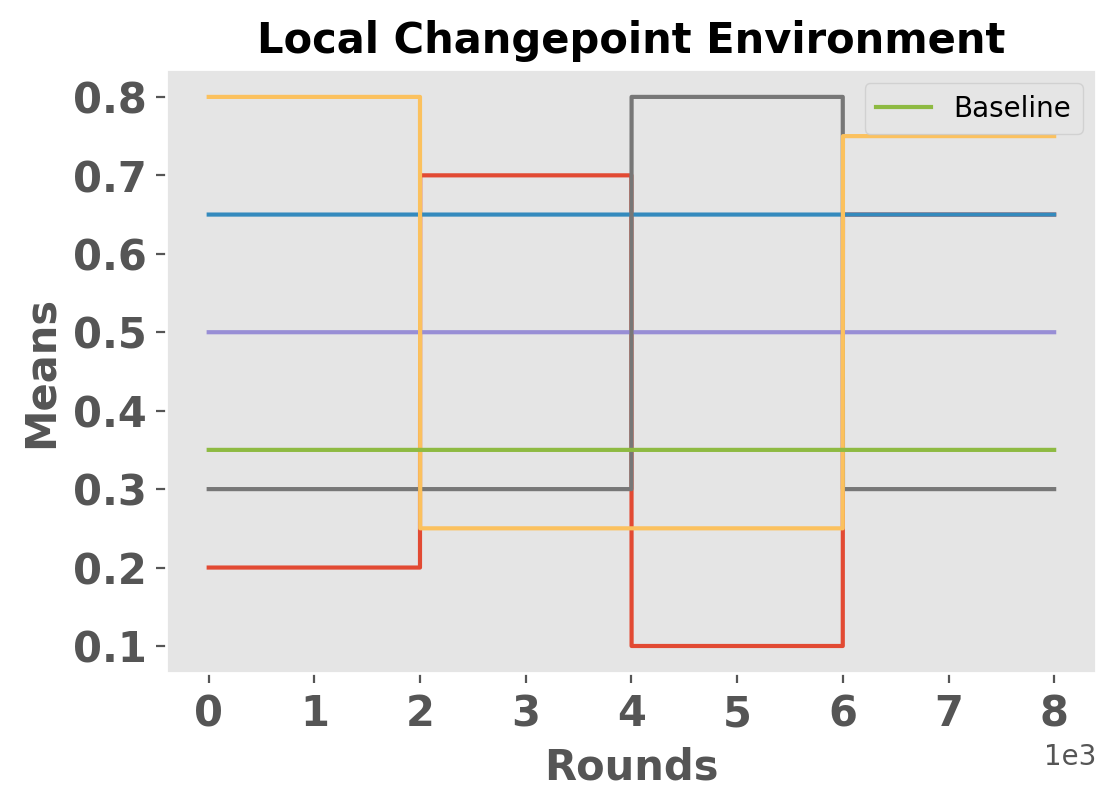

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


env = build_environment(5, 0.4, 8000, 10)
env.build_env1()
print(env.true_epsilon_arms)

plt.style.use('ggplot')
plt.figure(dpi=200)
# plt.plot([i for i in range(0,8000)], [env.threshold for i in range(0,8000)], '--', color='b', label = "Threshold")
#plt.plot([i for i in range(0,8000)], [1.5*env.threshold for i in range(0,8000)], '--', color='b')
#plt.plot(env.mu, 'ro')
plt.plot([i for i in range(0,8000)], env.mu_t[0:8000, 0:env.K-1])
plt.plot([i for i in range(0,8000)], env.mu_t[0:8000, env.K-1], label = "Baseline")

plt.title('Local Changepoint Environment', size = 15, fontweight='bold')
plt.ylabel('Means', size = 15, fontweight='bold')
plt.xlabel('Rounds', size = 15, fontweight='bold')
    
plt.yticks(size = 15, fontweight='bold')
plt.xticks(size = 15, fontweight='bold')

#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))



plt.legend()
plt.grid()
plt.show()

# Set Parameters

In [ ]:
T = 8000
trials = 10
env = build_environment(5, 0.4, T, trials)
env.build_env1()

[2000, 4000, 6000, 8000] 4


# Unbalanced MOSS

In [ ]:
import numpy as np

class UMOSS_Sampling(object):

  def __init__(self, env, confidence, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))




  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.B = np.zeros(self.K)
    while self.t < self.T:
      
      for k in range(self.K):

        if k == self.env.baseline:
          self.B[k] = (self.T*self.K)/(np.sqrt(self.T*self.K) + (self.K/(self.alpha*self.env.mu_t[self.t][self.env.baseline])))
        else:
          self.B[k] = np.sqrt(self.T*self.K) + (self.K/(self.alpha*self.env.mu_t[self.t][self.env.baseline]))
        
        n_k = (self.B[k]*self.B[k])/(self.T*self.T)
        beta_ucb = np.sqrt(4.0*np.log(max(0, (n_k/ (np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) ) ))/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1)) - np.sqrt(1.0/n_k)
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      arm = np.argmax(self.ucb)

      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      self.budget +=  self.lcb[arm] + self.ucb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.ucb[self.env.baseline]
      #self.budget_error += self.env.mu_t[self.t][arm] + self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm]
      #self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmin(self.env.mu_t[self.t])]
      

      error1 = 0
      
      #max(-1.0*self.budget_error,0.0)
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        #print(np.sum(self.tp), [int(self.tp[i]) for i in range(self.K)])
        #print(np.sum(self.numplays[int(np.min(self.ts)):int(np.max(self.tp)),:], axis = 1))
        #print(self.numplays[int(self.ts[2]):int(self.tp[2]),2], np.shape(self.numplays[int(self.ts[2]):int(self.tp[2]),2]))
        #print(self.numplays[int(self.ts[2]):self.t,2], np.sum(self.numplays[int(self.ts[2]):self.t,2]))
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print()
      
      self.t += 1

  def run_UMOSS_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
umoss = UMOSS_Sampling(env, 0.10, "global")
umoss.run_UMOSS_sampling()




0, t 100
t reward-arm: [19.14707330515005, 0.6900157208367224, 0.597873798410574, 0.5240893199201457, 0.9867557990149968, 0.2522722120123589]
t numplay: [95.0, 1.0, 1.0, 1.0, 1.0, 1.0] 100.0
t mu-hat: [0.1994486802619797, 0.3450078604183612, 0.298936899205287, 0.26204465996007287, 0.4933778995074984, 0.12613610600617944]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 57.00000000000009
4 4

t 200
t reward-arm: [39.96720301262843, 0.6900157208367224, 0.597873798410574, 0.5240893199201457, 0.9867557990149968, 0.2522722120123589]
t numplay: [195.0, 1.0, 1.0, 1.0, 1.0, 1.0] 200.0
t mu-hat: [0.20391430108483893, 0.3450078604183612, 0.298936899205287, 0.26204465996007287, 0.4933778995074984, 0.12613610600617944]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 116.9999999999996
4 4

t 300
t reward-arm: [59.374880407031796, 0.6900157208367224, 0.597873798410574, 0.5240893199201457, 0.9867557990149968, 0.2522722120123589]
t numplay: [295.0, 1.0, 1.0, 1.0, 1.0, 1.0] 300.0
t mu-hat: [0.2005908121

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in sqrt


Streaming output truncated to the last 5000 lines.
4 4

t 7700
t reward-arm: [3092.9419716775246, 0.6900157208367224, 0.597873798410574, 0.5240893199201457, 0.9867557990149968, 0.2522722120123589]
t numplay: [7695.0, 1.0, 1.0, 1.0, 1.0, 1.0] 7700.0
t mu-hat: [0.4018895493343977, 0.3450078604183612, 0.298936899205287, 0.26204465996007287, 0.4933778995074984, 0.12613610600617944]
T true mu: [0.65 0.65 0.5  0.3  0.75 0.35] Err: 2766.4999999997594
4 4

t 7800
t reward-arm: [3159.538358372311, 0.6900157208367224, 0.597873798410574, 0.5240893199201457, 0.9867557990149968, 0.2522722120123589]
t numplay: [7795.0, 1.0, 1.0, 1.0, 1.0, 1.0] 7800.0
t mu-hat: [0.40527685458854684, 0.3450078604183612, 0.298936899205287, 0.26204465996007287, 0.4933778995074984, 0.12613610600617944]
T true mu: [0.65 0.65 0.5  0.3  0.75 0.35] Err: 2776.4999999997503
4 4

t 7900
t reward-arm: [3224.025909853513, 0.6900157208367224, 0.597873798410574, 0.5240893199201457, 0.9867557990149968, 0.2522722120123589]
t numplay:

# DUCB

In [ ]:
import numpy as np

class DUCB_Sampling(object):

  def __init__(self, env, confidence, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))




  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.B = np.zeros(self.K)

    self.gamma = 1 - (1/(4.0*np.sqrt(self.T)))
    while self.t < self.T:
      
      for k in range(self.K):

        
        beta_ucb = 2.0*np.sqrt(2.0*np.log(self.t+1.0)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        #print(beta_ucb)
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      arm = np.argmax(self.ucb)

      reward = self.gamma*self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = self.gamma*1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[np.argmin(self.env.safe_arm_t[self.t])]
      #self.budget_error += self.env.mu_t[self.t][arm] + self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm]
      #self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmin(self.env.mu_t[self.t])]
      

      error1 = 0
      
      #max(-1.0*self.budget_error,0.0)
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        #print(np.sum(self.tp), [int(self.tp[i]) for i in range(self.K)])
        #print(np.sum(self.numplays[int(np.min(self.ts)):int(np.max(self.tp)),:], axis = 1))
        #print(self.numplays[int(self.ts[2]):int(self.tp[2]),2], np.shape(self.numplays[int(self.ts[2]):int(self.tp[2]),2]))
        #print(self.numplays[int(self.ts[2]):self.t,2], np.sum(self.numplays[int(self.ts[2]):self.t,2]))
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print()
      
      self.t += 1

  def run_DUCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
ducb = DUCB_Sampling(env, 0.10, "local")
ducb.run_DUCB_sampling()




Streaming output truncated to the last 5000 lines.
3 4

t 7700
t reward-arm: [797.0428853069195, 759.9167299749329, 206.65182190870973, 1705.8317239354367, 1604.8023435149623, 87.68859557196761]
t numplay: [1221.5788159944252, 1173.7129800730754, 425.8092938019813, 2368.3644682767685, 2242.7166489832257, 246.31240909691877] 7678.494616226397
t mu-hat: [0.6519357892346745, 0.6468956612088007, 0.4841783553208804, 0.7199532814704876, 0.7152428735786236, 0.3545660967525633]
T true mu: [0.65 0.65 0.5  0.3  0.75 0.35] Err: 686.1000000000225
3 4

t 7800
t reward-arm: [807.7247343606546, 765.0070408020201, 208.06782941743876, 1706.9639919668411, 1657.9280370500535, 87.6885955719676]
t numplay: [1237.5340946348754, 1181.6906193933, 428.8009085470658, 2372.353287936881, 2311.523788120166, 246.3124090969188] 7778.215107729209
t mu-hat: [0.652161888687267, 0.6468361448528742, 0.4841028143025763, 0.7192203540209887, 0.716934478930386, 0.3545660967525632]
T true mu: [0.65 0.65 0.5  0.3  0.75 0.35] E

# UCB-CPD

In [ ]:
import numpy as np

class UCB_Sampling(object):

  def __init__(self, env, confidence, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      for t_ in range(int(ts[k])+1,self.t):

        self.confidence = 1.0/self.t
        beta_ts = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            break
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t

            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue



  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    #Sample each arm once

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.gamma = np.sqrt(np.log(self.T)/self.T)

    while self.t < self.T:
      
      for k in range(self.K):

        beta_ucb = np.sqrt(1.0*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      if self.t% (self.K/self.gamma) <= self.K:
        arm = np.random.randint(0, self.K-1)
        #print("fe", arm, self.t% (self.K/self.gamma))
      else:
        arm = np.argmax(self.ucb)

      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[np.argmin(self.env.safe_arm_t[self.t])]
      #self.budget_error += self.env.mu_t[self.t][arm] + self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm]
      #self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmin(self.env.mu_t[self.t])]


      if self.t%20 == 0:
        self.detect_changepoint(self.ts, self.tp)
      
      

      error1 = 0
      
      #max(-1.0*self.budget_error,0.0)
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        #print(np.sum(self.tp), [int(self.tp[i]) for i in range(self.K)])
        #print(np.sum(self.numplays[int(np.min(self.ts)):int(np.max(self.tp)),:], axis = 1))
        #print(self.numplays[int(self.ts[2]):int(self.tp[2]),2], np.shape(self.numplays[int(self.ts[2]):int(self.tp[2]),2]))
        #print(self.numplays[int(self.ts[2]):self.t,2], np.sum(self.numplays[int(self.ts[2]):self.t,2]))
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print()
      
      self.t += 1

  def run_UCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
ucb = UCB_Sampling(env, 0.10, "local")
ucb.run_UCB_sampling()




Streaming output truncated to the last 5000 lines.
14175.796735704977 0

t 1400
t reward-arm: [2.9054444993337842, 99.63461547072264, 23.408999978117244, 8.796971976763361, 894.2300073870151, 9.893399566871633]
t numplay: [17.0, 154.0, 50.0, 28.0, 1122.0, 29.0] 1400.0
t mu-hat: [0.16141358329632136, 0.6428039707788558, 0.45899999957092635, 0.3033438612677021, 0.7962867385458727, 0.32977998556238775]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 73.34999999999994
4 4
14284.348402603815 0

t 1500
t reward-arm: [2.9054444993337842, 101.26052878638338, 23.765712704606145, 9.285652835678533, 968.6729166060289, 10.160381885858488]
t numplay: [17.0, 157.0, 51.0, 30.0, 1215.0, 30.0] 1500.0
t mu-hat: [0.16141358329632136, 0.6408894226986289, 0.45703293662704125, 0.2995371882476946, 0.7966060169457475, 0.32775425438253186]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 75.54999999999995
4 4
14394.764518769602 0

t 1600
t reward-arm: [2.996957216826062, 103.73485691950677, 23.765712704606145, 

# GLR-UCB

In [ ]:
import numpy as np
import math

class GLR_UCB_Sampling(object):

  def __init__(self, env, confidence, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  
  def klGauss(self, x, y, sig2 = 0.1):
        """caution modified"""
        """Kullback-Leibler divergence for Gaussian distributions."""
        return ((x-y)*(x-y))/(2*sig2)

  def klucbGauss(self, x, d, sig2=1., precision=0.):
      """klUCB index computation for Gaussian distributions.
    
      Note that it does not require any search.
      """
      #print 2.0*sig2*d, x
      return x + math.sqrt(2.0*sig2*d)

  def klucb(self, x, d, upperbound, lowerbound=-float('inf'), precision=1e-6):
    
        """The generic klUCB index computation.
    
        Input args.: x, d, div, upperbound, lowerbound=-float('inf'), precision=1e-6,
        where div is the KL divergence to be used.
        """
        l = max(x, lowerbound)
        u = upperbound
        while u-l > precision:
            m = (l+u)/2
            if self.klGauss(x, m) > d:
                u = m
            else:
                l = m
        return (l+u)/2

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      kl_list = []
      for t_ in range(int(ts[k])+1,self.t):

        # self.klucb(self.global_payoffSums[actionTaken]/(self.global_numPlays[actionTaken]+1), 
        #(math.log(self.t+1) + self.c * math.log(math.log(self.t+1)))  / (self.global_numPlays[actionTaken]+1), 1e-4) # Could adapt tolerance to the value of self.t


        
        # beta_ts = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        # beta_tp = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        # beta_ts = 5.0*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1)
        # beta_tp = 5.0*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1)

        emp_mean_ts = np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1)
        emp_mean_tp = np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1)
        emp_mean_tot = np.sum(self.reward_arm[int(ts[k]):self.t, k])/(np.sum(self.numplays[int(ts[k]):self.t, k]) + 1)

        s = np.sum(self.numplays[int(ts[k]):t_, k])+1
        n = (np.sum(self.numplays[t_:self.t, k]) + 1)
        n_s = n - s

        #kl_list.append(s*self.klucb(emp_mean_ts, emp_mean_tot, 1e-4) + n_s*self.klucb(emp_mean_tp, emp_mean_tot, 1e-4))
        kl_list.append(s*self.klGauss(emp_mean_ts, emp_mean_tot) + n_s*self.klGauss(emp_mean_tp, emp_mean_tot))
      
      self.confidence = 1.0/self.t
      self.conf_inf = 1.0*np.log(3.0*math.pow(self.t,3.0/2.0)/self.confidence)
      #self.conf_inf = 8.0*np.log(3.0*self.t)


      if max(kl_list) > self.conf_inf:
        
        #if s*self.klGauss(emp_mean_ts, emp_mean_tot) + n_s*self.klGauss(emp_mean_tp, emp_mean_tot) > self.conf_inf:
          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            break
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t

            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue



  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.gamma = np.sqrt(np.log(self.T)/self.T)

    while self.t < self.T:
      
      for k in range(self.K):

        beta_ucb = np.sqrt(1.0*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      
      if self.t% (self.K/self.gamma) <= self.K:
        arm = np.random.randint(0, self.K-1)
        #print("fe", arm, self.t% (self.K/self.gamma))
      else:
        arm = np.argmax(self.ucb)

      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[np.argmin(self.env.safe_arm_t[self.t])]
      #self.budget_error += self.env.mu_t[self.t][arm] + self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm]
      #self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmin(self.env.mu_t[self.t])]


      if self.t%20 == 0:
        self.detect_changepoint(self.ts, self.tp)
      
      

      error1 = 0
      
      #max(-1.0*self.budget_error,0.0)
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        #print(np.sum(self.tp), [int(self.tp[i]) for i in range(self.K)])
        #print(np.sum(self.numplays[int(np.min(self.ts)):int(np.max(self.tp)),:], axis = 1))
        #print(self.numplays[int(self.ts[2]):int(self.tp[2]),2], np.shape(self.numplays[int(self.ts[2]):int(self.tp[2]),2]))
        #print(self.numplays[int(self.ts[2]):self.t,2], np.sum(self.numplays[int(self.ts[2]):self.t,2]))
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print()
      
      self.t += 1

  def run_GLR_UCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
glrucb = GLR_UCB_Sampling(env, 0.10, "local")
glrucb.run_GLR_UCB_sampling()




Streaming output truncated to the last 5000 lines.
t 1300
t reward-arm: [2.9054444993337842, 98.10972386278752, 22.425421353370382, 8.796971976763361, 819.7294677620499, 9.46492790211226]
t numplay: [17.0, 151.0, 48.0, 28.0, 1028.0, 28.0] 1300.0
t mu-hat: [0.16141358329632136, 0.6454587096236021, 0.4576616602728649, 0.3033438612677021, 0.796627276736686, 0.3263768242107676]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 71.84999999999992
4 4
14729.880100188995 0

t 1400
t reward-arm: [2.9054444993337842, 99.63461547072264, 23.408999978117244, 8.796971976763361, 894.2300073870151, 9.893399566871633]
t numplay: [17.0, 154.0, 50.0, 28.0, 1122.0, 29.0] 1400.0
t mu-hat: [0.16141358329632136, 0.6428039707788558, 0.45899999957092635, 0.3033438612677021, 0.7962867385458727, 0.32977998556238775]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 73.34999999999994
4 4
14838.431767087834 0

t 1500
t reward-arm: [2.9054444993337842, 101.26052878638338, 23.765712704606145, 9.285652835678533, 968.6729

# Conservative-UCB

In [ ]:
import numpy as np

class CUCB_Sampling(object):

  def __init__(self, env, confidence, alpha, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      for t_ in range(int(ts[k])+1,self.t):

        
        beta_ts = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            return True
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t

            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue



  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.budget = 0

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)

    while self.t < self.T:
      
      for k in range(self.K):

        beta_ucb = np.sqrt(1.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      if self.budget >= 0:
        arm = np.argmax(self.ucb)
      else:
        #arm = self.env.safe_arm
        arm = self.env.baseline

      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      #self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])]
      #print(self.env.baseline)
      #self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.ucb[self.env.baseline] - self.alpha*self.env.threshold
      #self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.ucb[self.env.baseline]
      self.budget +=  self.lcb[arm] + self.ucb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.ucb[self.env.baseline]
      
      #self.budget_error += self.env.mu_t[self.t][arm] + self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm]
      #self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])]


      # if self.t%20 == 0:
      #   self.detect_changepoint(self.ts, self.tp)
      

      error1 = 0
      
      
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        #print(np.sum(self.tp), [int(self.tp[i]) for i in range(self.K)])
        #print(np.sum(self.numplays[int(np.min(self.ts)):int(np.max(self.tp)),:], axis = 1))
        #print(self.numplays[int(self.ts[2]):int(self.tp[2]),2], np.shape(self.numplays[int(self.ts[2]):int(self.tp[2]),2]))
        #print(self.numplays[int(self.ts[2]):self.t,2], np.sum(self.numplays[int(self.ts[2]):self.t,2]))
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print()
      
      self.t += 1

  def run_CUCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
cucb = CUCB_Sampling(env, 0.10, 0.1, "local")
cucb.run_CUCB_sampling()




Streaming output truncated to the last 5000 lines.
t 800
t reward-arm: [4.057508933754806, 83.13870234214555, 27.2530865213655, 7.317848459391094, 419.5798690199199, 14.002995467629574]
t numplay: [22.0, 130.0, 57.0, 27.0, 526.0, 38.0] 800.0
t mu-hat: [0.17641343190238287, 0.6346465827644698, 0.4698808020925086, 0.2613517306925391, 0.7961667343831497, 0.35905116583665575]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 78.4
4 4
916.8572986374452 0

t 900
t reward-arm: [4.256826184338548, 91.12296878944755, 27.993660031320363, 7.860454203684698, 485.46209591896934, 14.393790303896617]
t numplay: [23.0, 142.0, 59.0, 29.0, 608.0, 39.0] 900.0
t mu-hat: [0.17736775768077284, 0.6372235579681648, 0.46656100052200605, 0.2620151401228233, 0.7971462987175194, 0.3598447575974154]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 82.85000000000007
4 4
1040.0625285716346 0

t 1000
t reward-arm: [4.256826184338548, 99.0148568371509, 29.422789353381045, 7.957009080706403, 550.5736782258889, 15.03984679

#Adversarial CUCB

In [ ]:
import numpy as np

class Adv_CUCB_Sampling(object):

  def __init__(self, env, confidence, alpha, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      for t_ in range(int(ts[k])+1,self.t):

        
        beta_ts = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            return True
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t

            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue



  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.budget = 0

    #Sample each arm once
    
    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1


    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)

    self.gamma = np.sqrt((self.K*np.log(self.K)*np.log(self.T))/(self.T))
    sum1 = 0.0
    self.prob = np.ones(self.K)
    
    sum_prob = np.sum(self.prob)
    for k in range(0,self.K):
      self.prob[k] = self.prob[k]/sum_prob

    
    self.weights = np.ones(self.K)

    while self.t < self.T:
      
      for k in range(self.K):
        self.confidence = 1.0/self.confidence
        beta_ucb = np.sqrt(1.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)
        self.prob[k] = (1-self.gamma)*(self.weights[k]/sum(self.weights))+(self.gamma/self.K)


      

      sum_prob = np.sum(self.prob)
      for k in range(0,self.K):
        self.prob[k] = self.prob[k]/sum_prob

      #print(self.prob)
      if self.budget >= 0:
        arm = np.random.choice(self.K, p = self.prob)
      else:
        #arm = self.env.safe_arm
        arm = self.env.baseline

      reward = self.env.pull_arm(arm, self.t)

      xj=[0.0]*self.K

      for k in range(self.K):

        if k == arm:
          xj[k] = reward/self.prob[k]

        self.weights[k]=self.weights[k]*np.exp(self.gamma*xj[k]/self.K)
      
      #print(arm, self.budget)


      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      #self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])]
      #print(self.env.baseline)
      self.budget +=  self.lcb[arm] + self.ucb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.ucb[self.env.baseline]
      #self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[self.env.baseline]
      
      #self.budget_error += self.env.mu_t[self.t][arm] + self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm]
      #self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])]


      # if self.t%20 == 0:
      #   self.detect_changepoint(self.ts, self.tp)
      

      error1 = 0
      
      
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        #print(np.sum(self.tp), [int(self.tp[i]) for i in range(self.K)])
        #print(np.sum(self.numplays[int(np.min(self.ts)):int(np.max(self.tp)),:], axis = 1))
        #print(self.numplays[int(self.ts[2]):int(self.tp[2]),2], np.shape(self.numplays[int(self.ts[2]):int(self.tp[2]),2]))
        #print(self.numplays[int(self.ts[2]):self.t,2], np.sum(self.numplays[int(self.ts[2]):self.t,2]))
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print(self.prob)
        print()
      
      self.t += 1

  def run_Adv_CUCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
adv_cucb = Adv_CUCB_Sampling(env, 0.10, 0.1, "local")
adv_cucb.run_Adv_CUCB_sampling()




0, t 100
t reward-arm: [0.37640523459676645, 0.6900157208367224, 1.2244856513963518, 0.5240893199201457, 0.9867557990149968, 33.765289230032636]
t numplay: [1.0, 1.0, 2.0, 1.0, 1.0, 94.0] 100.0
t mu-hat: [0.18820261729838322, 0.3450078604183612, 0.40816188379878393, 0.26204465996007287, 0.4933778995074984, 0.35542409715823825]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 42.60000000000003
4 4
nan 0
[0.09444366 0.09444366 0.09987069 0.09444366 0.09444366 0.52235469]

t 200
t reward-arm: [0.37640523459676645, 0.6900157208367224, 1.2244856513963518, 0.5240893199201457, 0.9867557990149968, 68.29092847416781]
t numplay: [1.0, 1.0, 2.0, 1.0, 1.0, 194.0] 200.0
t mu-hat: [0.18820261729838322, 0.3450078604183612, 0.40816188379878393, 0.26204465996007287, 0.4933778995074984, 0.350209889611117]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 87.6000000000003
4 4
nan 0
[0.05646889 0.05646889 0.05918876 0.05646889 0.05646889 0.71493568]

t 300
t reward-arm: [0.37640523459676645, 0.69001572083672

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in sqrt


Streaming output truncated to the last 5000 lines.
T true mu: [0.65 0.65 0.5  0.3  0.75 0.35] Err: 3177.399999999908
1 4
nan 0
[0.01831603 0.01831603 0.01831603 0.01831603 0.01831603 0.90841985]

t 7800
t reward-arm: [0.15832421525945295, 1.144272629902115, 0.28638039043315455, 0.4640270808404989, 0.6206564414805137, 2717.187038344209]
t numplay: [1.0, 2.0, 1.0, 1.0, 1.0, 7794.0] 7800.0
t mu-hat: [0.07916210762972647, 0.3814242099673717, 0.14319019521657728, 0.23201354042024944, 0.31032822074025684, 0.3485807618145233]
T true mu: [0.65 0.65 0.5  0.3  0.75 0.35] Err: 3217.399999999917
1 4
nan 0
[0.01831603 0.01831603 0.01831603 0.01831603 0.01831603 0.90841985]

t 7900
t reward-arm: [0.15832421525945295, 1.144272629902115, 0.28638039043315455, 0.4640270808404989, 0.6206564414805137, 2753.386849032605]
t numplay: [1.0, 2.0, 1.0, 1.0, 1.0, 7894.0] 7900.0
t mu-hat: [0.07916210762972647, 0.3814242099673717, 0.14319019521657728, 0.23201354042024944, 0.31032822074025684, 0.34875070918715706]


# SLR 

In [ ]:
import numpy as np

class SLR_Sampling(object):

  def __init__(self, env, confidence, alpha, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      for t_ in range(int(ts[k])+1,self.t):

        
        beta_ts = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t
              self.safe_set = set()
              self.budget = 0.0
              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            return True
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t
            self.safe_set = set()
            self.budget = 0.0

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue

  def safe_set_function(self, ):
    
    self.safe_set = set()
    for k in range(0, self.K-1):

      #mu_hat = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1)
      #if self.lcb[k] > self.env.threshold and self.ucb[k] < 1.5*self.env.threshold:
      #if self.lcb[k] > self.env.threshold:
      #if self.mu_hat[self.t-1][k] > self.env.threshold and self.mu_hat[self.t-1][k]  < 1.5*self.env.threshold:
      if self.mu_hat[self.t-1][k] >= self.alpha*self.env.threshold:
        
        self.safe_set.add((k, self.mu_hat[self.t-1][k]))
    
    return self.safe_set

  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.budget = 0

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.B = np.zeros(self.K)
    self.safe_set = set()
    self.gamma = np.sqrt(np.log(self.T)/self.T)

    while self.t < self.T:
      
      for k in range(self.K):

        beta_ucb = np.sqrt(1.0*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)
        self.B[k] = abs(np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - self.alpha*self.env.threshold)*np.sqrt((np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))

      
      self.safe_set = self.safe_set_function()

      if self.budget >= 0:
        if self.t% (self.K/self.gamma) <= self.K:
          arm = np.random.randint(0, self.K-1)
          #print("fe", arm, self.t% (self.K/self.gamma))
        else:
          arm = np.argmax(self.ucb)
      elif self.budget < 0:
        arm = self.env.baseline

      # if self.t% (self.K/self.gamma) <= self.K:
      #   arm = np.random.randint(0, self.K-1)
      #   #print("fe", arm, self.t% (self.K/self.gamma))
      # else:

      #   if self.budget >= 0 and len(self.safe_set) >= 1:
      #     arm = np.argmax(self.ucb)
      #   elif self.budget >= 0 and len(self.safe_set) == 0:
      #     arm = np.argmin(self.B)
      #   elif self.budget < 0 and len(self.safe_set) >= 1:
      #     #print(len(self.safe_set))
      #     #arm = np.random.choice(list(self.safe_set), 1)
      #     arm = min(self.safe_set, key = lambda x: x[1])[0]
      #   elif self.budget < 0 and len(self.safe_set) == 0:
      #     #arm = np.argmax(self.ucb)

      #     arm = self.env.baseline

      
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      # self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[self.env.safe_arm]
      # self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])]

      # self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[np.argmin(self.safe_set)]
      # self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmin(self.env.mu_t[self.t])]

      # if len(self.safe_set) > 0:
      #   self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[min(self.safe_set, key = lambda x: x[1])[0]]
      self.budget +=  self.lcb[arm] + self.ucb[np.argmax(self.mu_hat[self.t, :])] - (1.0 - self.alpha)*self.ucb[self.env.baseline]
      #self.budget_error += self.env.mu_t[self.t][arm] + self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm]
      #self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmin(self.env.mu_t[self.t])]


      if self.t%10 == 0:
        self.detect_changepoint(self.ts, self.tp)
        
      error1 = 0
      
      
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        #print(np.sum(self.tp), [int(self.tp[i]) for i in range(self.K)])
        #print(np.sum(self.numplays[int(np.min(self.ts)):int(np.max(self.tp)),:], axis = 1))
        #print(self.numplays[int(self.ts[2]):int(self.tp[2]),2], np.shape(self.numplays[int(self.ts[2]):int(self.tp[2]),2]))
        #print(self.numplays[int(self.ts[2]):self.t,2], np.sum(self.numplays[int(self.ts[2]):self.t,2]))
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error, self.safe_set)
        print()
      
      self.t += 1

  def run_SLR_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
slr = SLR_Sampling(env, 0.10, 0.1, "local")
slr.run_SLR_sampling()




Streaming output truncated to the last 5000 lines.
t mu-hat: [0.19351502951255747, 0.6523567415452949, 0.4594225870988182, 0.2958490092555782, 0.7947241900021577, 0.32229874098015826]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 45.3499999999999
4 4
1618.1195497320853 0 {(3, 0.2958490092555782), (2, 0.4594225870988182), (1, 0.6523567415452949), (4, 0.7948268102973393)}

t 1400
t reward-arm: [2.3221803541506896, 69.02519152645043, 14.242100200063366, 6.212829194367142, 969.2155113721609, 5.101626231631192]
t numplay: [11.0, 105.0, 30.0, 20.0, 1219.0, 15.0] 1400.0
t mu-hat: [0.19351502951255747, 0.6511810521363248, 0.4594225870988182, 0.2958490092555782, 0.7944389437476729, 0.3188516394769495]
T true mu: [0.2  0.65 0.5  0.3  0.8  0.35] Err: 46.0999999999999
4 4
1750.5539639863234 0 {(3, 0.2958490092555782), (2, 0.4594225870988182), (1, 0.6511810521363248), (4, 0.794426434163833)}

t 1500
t reward-arm: [2.3221803541506896, 70.15119758181679, 14.598812926552267, 6.701510053282314, 1045.

# File Save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
file = open('/content/drive/My Drive/Expts/SafeChangepoint/Local_Data6', 'wb')

A = umoss.error
B = ucb.error
C = cucb.error
D = glrucb.error
E = slr.error
F = ducb.error

pickle.dump([A, B, C, D, E, F],file) # dump information to that file

file.close()

# Load Data

In [ ]:
import pickle 
file = open('/content/drive/My Drive/Expts/SafeChangepoint/Local_Data5', 'rb')
data = pickle.load(file)
file.close()

# umoss = UMOSS_Sampling(env, 0.10, 0.1, "local")
# ucb = UCB_Sampling(env, 0.10, "local")
# cucb = CUCB_Sampling(env, 0.10, 0.1, "local")
# glrucb = GLR_UCB_Sampling(env, 0.10, "local")
# slr = SLR_Sampling(env, 0.10, 0.1, "local")


umoss.error = data[0]
ucb.error = data[1]
cucb.error = data[2]
glrucb.error = data[3]
slr.error = data[4]
ducb.error = data[5]

print(data[0])

[[   0.     0.     0.  ... 2796.2 2796.3 2796.4]
 [   0.     0.     0.  ... 2796.2 2796.3 2796.4]
 [   0.     0.     0.  ... 2796.2 2796.3 2796.4]
 ...
 [   0.     0.     0.  ... 2796.2 2796.3 2796.4]
 [   0.     0.     0.  ... 2796.2 2796.3 2796.4]
 [   0.     0.     0.  ... 2796.2 2796.3 2796.4]]


# Regret Plot

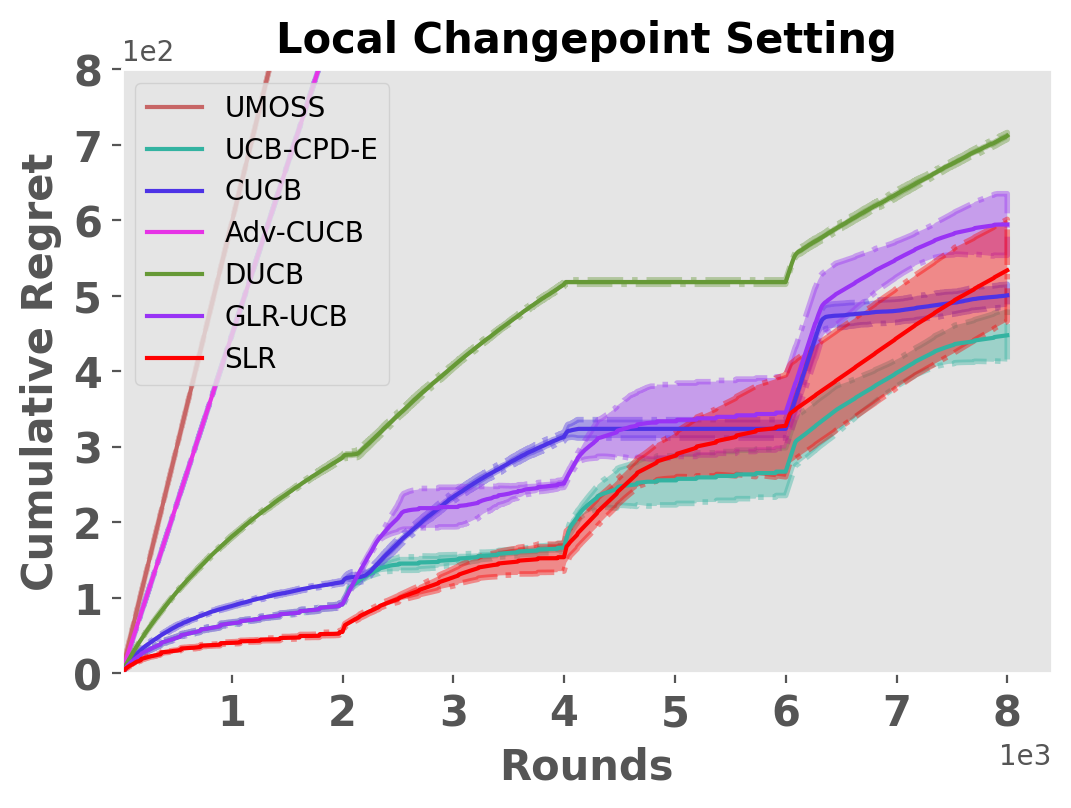

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(dpi=200)
k = 1.0

plt.plot(np.mean(umoss.error, axis = 0), label = "UMOSS", color = (0.78,0.4,0.4))
plt.fill_between(range(env.T), np.average(umoss.error, axis=0) + k*np.std(umoss.error, axis=0), np.average(umoss.error, axis=0) - k*np.std(umoss.error, axis=0), alpha=0.4, edgecolor=(0.78,0.4,0.4), facecolor=(0.78,0.4,0.4), linewidth=2, linestyle='dashdot', antialiased=True)


plt.plot(np.mean(ucb.error, axis = 0), label = "UCB-CPD-E", color = (0.2,0.7,0.63))
plt.fill_between(range(env.T), np.average(ucb.error, axis=0) + k*np.std(ucb.error, axis=0), np.average(ucb.error, axis=0) - k*np.std(ucb.error, axis=0), alpha=0.4, edgecolor=(0.2,0.7,0.63), facecolor=(0.2,0.7,0.63), linewidth=2, linestyle='dashdot', antialiased=True)

plt.plot(np.mean(cucb.error, axis = 0), label = "CUCB", color = (0.3,0.2,0.9))
plt.fill_between(range(env.T), np.average(cucb.error, axis=0) + k*np.std(cucb.error, axis=0), np.average(cucb.error, axis=0) - k*np.std(cucb.error, axis=0), alpha=0.4, edgecolor=(0.3,0.2,0.9), facecolor=(0.3,0.2,0.9), linewidth=2, linestyle='dashdot', antialiased=True)

plt.plot(np.mean(adv_cucb.error, axis = 0), label = "Adv-CUCB", color = (0.9,0.2,0.9))
plt.fill_between(range(env.T), np.average(adv_cucb.error, axis=0) + k*np.std(adv_cucb.error, axis=0), np.average(adv_cucb.error, axis=0) - k*np.std(adv_cucb.error, axis=0), alpha=0.4, edgecolor=(0.3,0.2,0.9), facecolor=(0.3,0.2,0.9), linewidth=2, linestyle='dashdot', antialiased=True)


plt.plot(np.mean(ducb.error, axis = 0), label = "DUCB", color = (0.4,0.6,0.21))
plt.fill_between(range(env.T), np.average(ducb.error, axis=0) + k*np.std(ducb.error, axis=0), np.average(ducb.error, axis=0) - k*np.std(ducb.error, axis=0), alpha=0.4, edgecolor=(0.4,0.6,0.21), facecolor=(0.4,0.6,0.21), linewidth=2, linestyle='dashdot', antialiased=True)

plt.plot(np.mean(glrucb.error, axis = 0), label = "GLR-UCB", color = (0.6,0.2,0.96))
plt.fill_between(range(env.T), np.average(glrucb.error, axis=0) + k*np.std(glrucb.error, axis=0), np.average(glrucb.error, axis=0) - k*np.std(glrucb.error, axis=0), alpha=0.4, edgecolor=(0.6,0.2,0.96), facecolor=(0.6,0.2,0.96), linewidth=2, linestyle='dashdot', antialiased=True)


plt.plot(np.mean(slr.error, axis = 0), label = "SLR", color = "r")
plt.fill_between(range(env.T), np.average(slr.error, axis=0) + k*np.std(slr.error, axis=0), np.average(slr.error, axis=0) - k*np.std(slr.error, axis=0), alpha=0.4, edgecolor="r", facecolor="r", linewidth=2, linestyle='dashdot', antialiased=True)


plt.title('Local Changepoint Setting', size = 15, fontweight='bold')
plt.ylabel('Cumulative Regret', size = 15, fontweight='bold')
plt.xlabel('Rounds', size = 15, fontweight='bold')
    
plt.yticks(size = 15, fontweight='bold')
plt.xticks(size = 15, fontweight='bold')

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))


plt.xlim(env.K)
plt.grid()
plt.legend()
plt.ylim(0,800)


plt.show()
